<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%EC%9D%B4%EC%9E%AC%EC%9C%A4/%5B240704%5D_Faiss%2C_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building RAG application using Langchain 🦜, OpenAI 🤖, FAISS
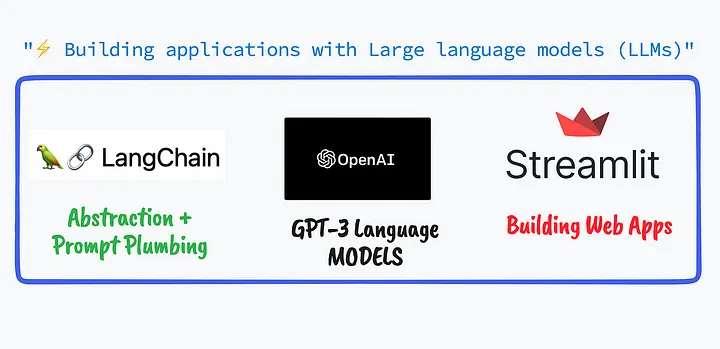

준비물: Openai API Key

RAG stands for Retrieval-Augmented Generation. These applications are used to integrate large language models (LLMs) into our own applications. RAG applications Involve integrating LLMs, prompts, user data which can be our own (.pdf) files , and query history to ask the LLM for specific outputs or answers based on the user’s query.

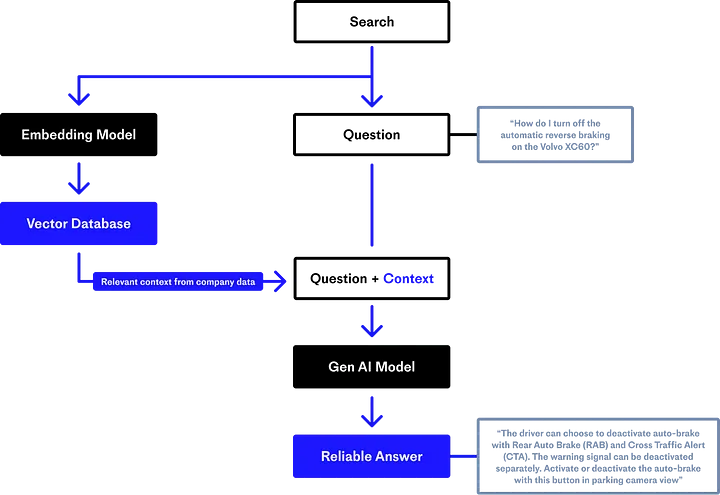

1.   Bi-encoder
- Bi-encoder encodes query and document independently
- Taking k nearest document embeddings from the query embedding (dot product or cosine similarity)
- Employs efficient maximum inner-product search algorithms allow for fast retrieval (e.g. FAISS)

2.   Cross-encoder
- Cross-encoder encodes concatenated input of query and document, and outputs the compatibility score
- Expensive with more fine-grained interaction



# FAISS
FAISS is an library stands for Facebook AI similarity search which is used to create embedding for documents and to perform similarity search operations on the document which are the form of embeddings or vectors of sentences in the document.langchain provides faiss module to be used on our application.

In [ ]:
!pip install langchain
!pip install streamlit -q
!pip install langchain-openai
!pip install langchain-community langchain-core
!pip install pypdf
!pip install sentence_transformers
!pip install faiss-cpu

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/FAISS')

# Building Some Vectors
The first thing we need is data, we’ll be taking an entailment dataset from semantic test similarity hub repo. We will download the dataset, and extract the relevant text columns into a single list.

In [ ]:
import requests
from io import StringIO
import pandas as pd

In [ ]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')
# create dataframe
data = pd.read_csv(StringIO(res.text), sep='\t')
data.head()

In [ ]:
# we take all samples from both sentence A and B
sentences = data['sentence_A'].tolist()
sentences[:5]

In [ ]:
# we take all samples from both sentence A and B
sentences = data['sentence_A'].tolist()
sentence_b = data['sentence_B'].tolist()
sentences.extend(sentence_b)  # merge them
len(set(sentences))  # together we have ~4.5K unique sentences

In [ ]:
# remove duplicates and NaN
sentences = [word for word in list(set(sentences)) if type(word) is str]

Here, we will use Huggingface sentencetransformer [링크 텍스트](https://huggingface.co/sentence-transformers)

In [ ]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:

# create sentence embeddings
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

There are several inices to measure distance between vector embeddings. HEre, we will try simple `IndexFlatL2`, which measures the L2 (or Euclidean) distance between all given points between our query vector, and the vectors loaded into the index. It’s simple, very accurate, but not too fast.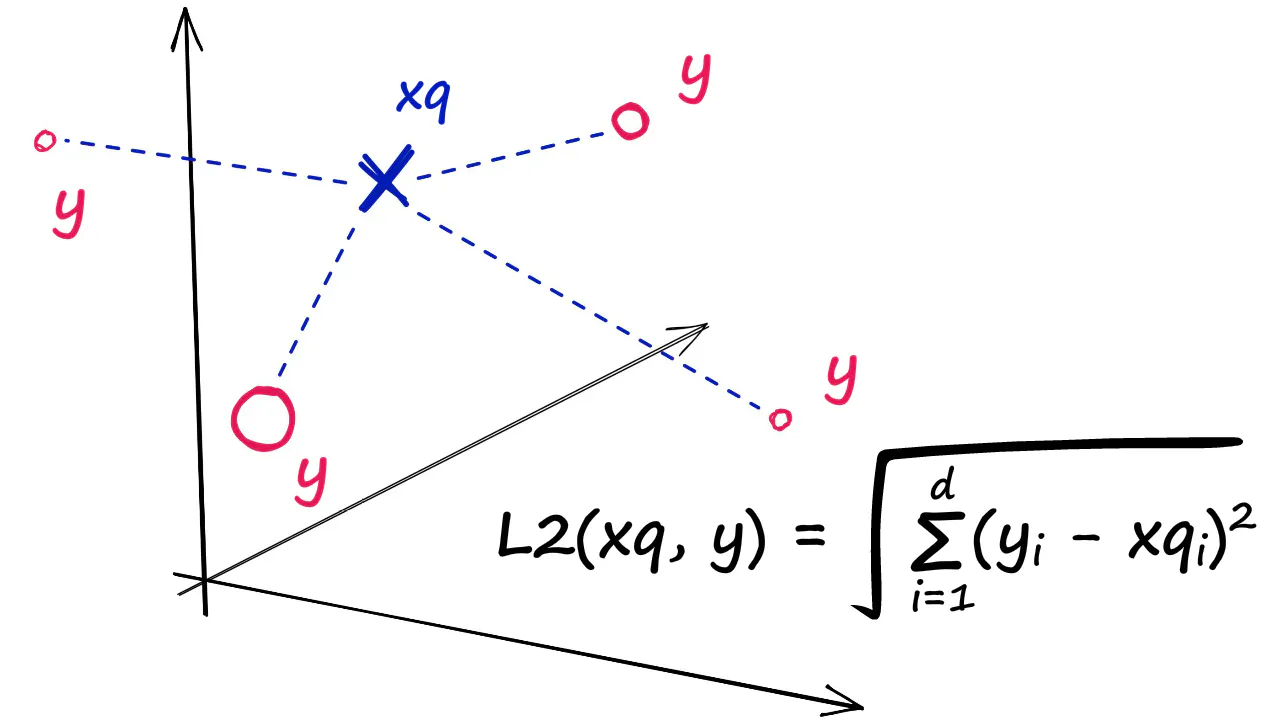

In [ ]:
import faiss


In [ ]:
d = sentence_embeddings.shape[1]
d

In [ ]:
index = faiss.IndexFlatL2(d)
index.add(sentence_embeddings)
index.ntotal

Then search given a query `xq` and number of nearest neigbors to return `k`.

In [ ]:
k = 20
query = "Schoolboys are throwing balls"
xq = model.encode([query])

In [ ]:
%%time
D, I = index.search(xq, k)  # search
print(I)

In [ ]:
for item in I[0]:
  print(item, sentences[item])

It returns the top k vectors closest to our query vector xq such as 2637, 1681, 2707... and so on. Clearly, these are all great matches — all including either people running with a football or in the context of a football match.

However, using the IndexFlatL2 index alone is computationally expensive, it doesn’t scale well. We need to do something different.

# Partitioning The Index
Faiss allows us to add multiple steps that can optimize our search using many different methods. A popular approach is to partition the index into Voronoi cells.
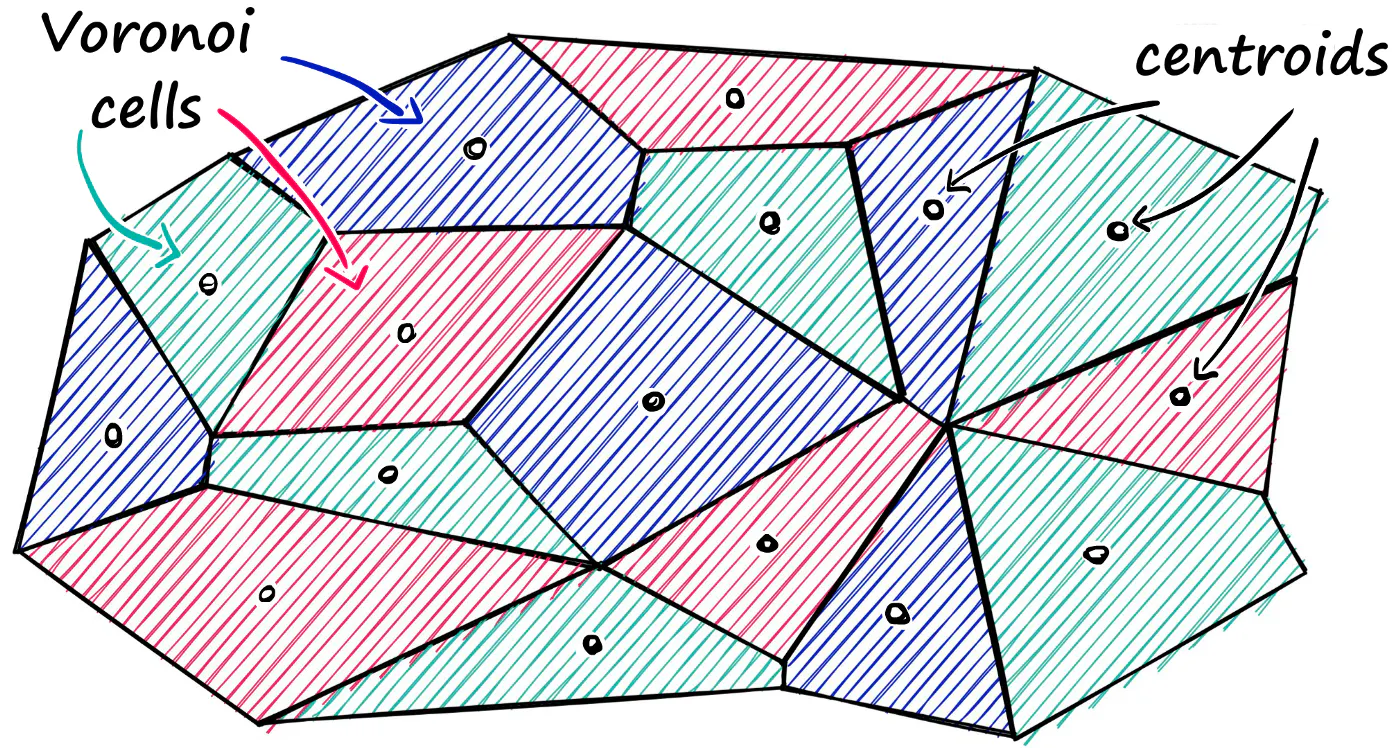

Using this method, we would take a query vector xq, identify the cell it belongs to, and then use our IndexFlatL2 (or another metric) to search between the query vector and all other vectors belonging to that specific cell.

So, we are reducing the scope of our search, producing an approximate answer, rather than exact (as produced through exhaustive search).

To implement this, we first initialize our index using IndexFlatL2 — but this time, we are using the L2 index as a quantizer step — which we feed into the partitioning IndexIVFFlat index.

In [ ]:
nlist = 50  # how many cells
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

Here we’ve added a new parameter nlist. We use nlist to specify how many partitions (Voronoi cells) we’d like our index to have.

Now, when we built the previous IndexFlatL2-only index, we didn’t need to train the index as no grouping/transformations were required to build the index. Because we added clustering with IndexIVFFlat, this is no longer the case.

So, what we do now is train our index on our data — which we must do before adding any data to the index.

In [ ]:
index.train(sentence_embeddings)
index.is_trained  # check if index is now trained

In [ ]:
index.add(sentence_embeddings)
index.ntotal  # number of embeddings indexed

In [ ]:
%%time
D, I = index.search(xq, k)  # search
print(I)

In [ ]:
for item in I[0]:
  print(item, sentences[item])

# Building Application with RAG

From now on, we will implement RAG with streamlit, OpenAI api, FAISS, and Langchain.
Running this cell should create a new file named vectorstore in your current directory.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

In [ ]:
!wget https://kr.object.ncloudstorage.com/bootc/random%20machine%20learing%20pdf.pdf

In [ ]:
loader=PyPDFLoader("./random machine learing pdf.pdf")
docs=loader.load()
api_key = ''

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = FAISS.from_documents(documents=splits, embedding=OpenAIEmbeddings(api_key=api_key))
vectorstore.save_local('./')

In [ ]:
%%writefile app.py
import streamlit as sl
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
api_key = ''

def load_knowledgeBase(api_key):
        embeddings=OpenAIEmbeddings(api_key=api_key)
        DB_FAISS_PATH = './'
        db = FAISS.load_local(DB_FAISS_PATH, embeddings, allow_dangerous_deserialization=True)
        return db

def load_prompt():
        prompt = """ You need to answer the question in the sentence as same as in the  pdf content. .
        Given below is the context and question of the user.
        context = {context}
        question = {question}
        if the answer is not in the pdf , answer "I do not know"
         """
        prompt = ChatPromptTemplate.from_template(prompt)
        return prompt

#to load the OPENAI LLM
def load_llm(api_key):
        from langchain_openai import ChatOpenAI
        llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, api_key=api_key)
        return llm

def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
sl.header("welcome to the pdf bot")
knowledgeBase=load_knowledgeBase(api_key)
llm=load_llm(api_key)
prompt=load_prompt()

query=sl.text_input('Enter some text')


if(query):
        #getting only the chunks that are similar to the query for llm to produce the output
        similar_embeddings=knowledgeBase.similarity_search(query)
        similar_embeddings=FAISS.from_documents(documents=similar_embeddings, embedding=OpenAIEmbeddings(api_key=api_key))

        #creating the chain for integrating llm,prompt,stroutputparser
        retriever = similar_embeddings.as_retriever()
        rag_chain = (
                {"context": retriever | format_docs, "question": RunnablePassthrough()}
                | prompt
                | llm
                | StrOutputParser()
            )

        response=rag_chain.invoke(query)
        sl.write(response)

In [ ]:
!wget -q -O - ipv4.icanhazip.com

After running the cell, click 'your url' and paste ip on the website.

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

# Bi-encoders and Cross-encoders
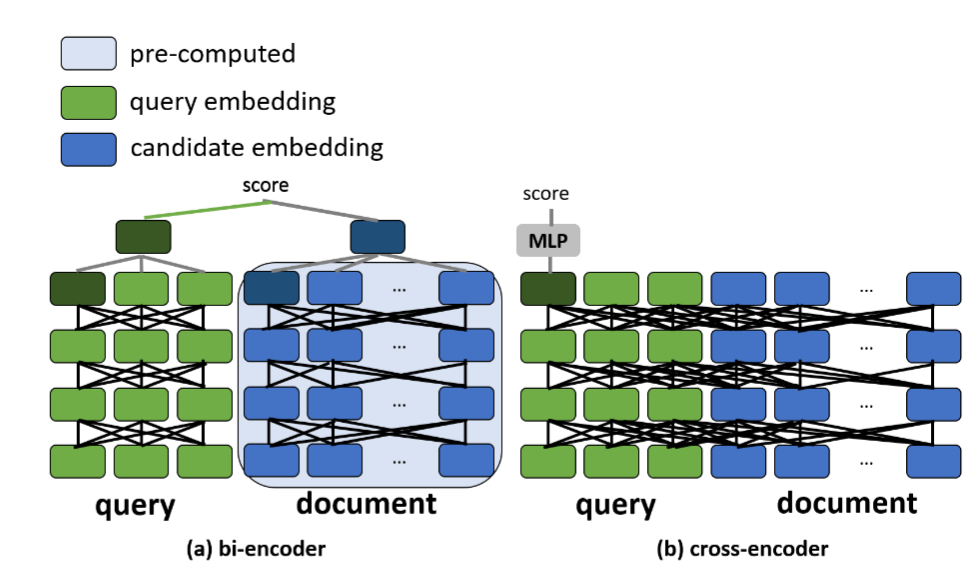

# Cross-encoders
cross-encoders are often employed to enhance the quality of retrieved candidates. [LINK](https://huggingface.co/cross-encoder) provides available listup for cross-encoders at huggingface.


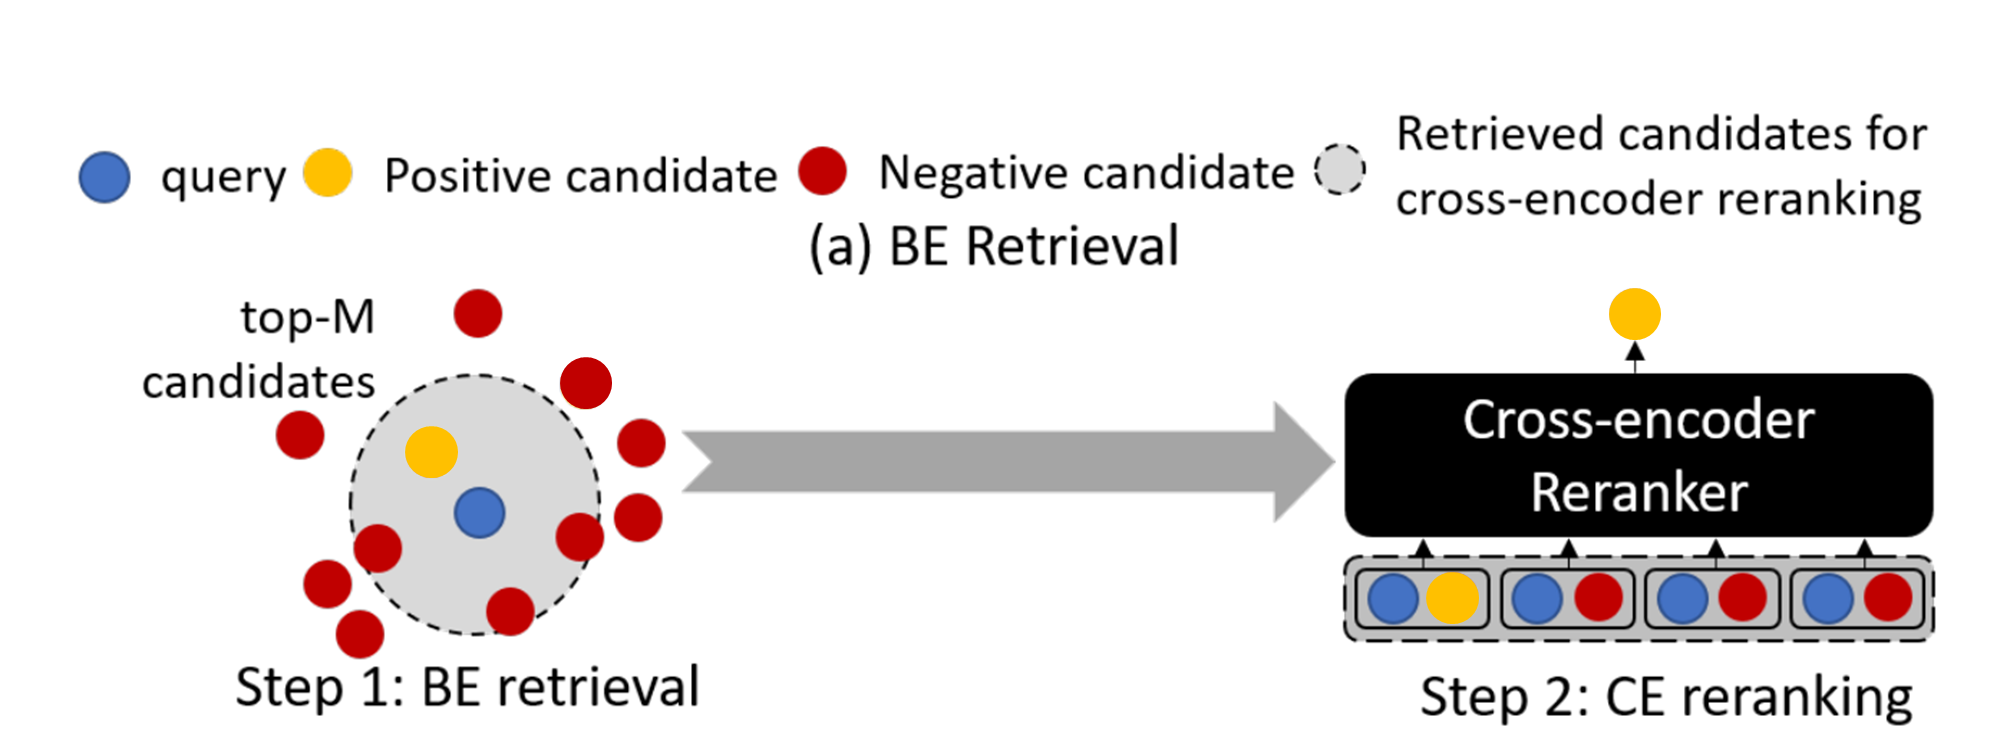

In [ ]:
from sentence_transformers import CrossEncoder
import numpy as np
model = CrossEncoder('cross-encoder/quora-roberta-large')
concatenated_sentences = [(query , sentences[item]) for item in I[0]]
for i in range(5):
  print(concatenated_sentences[:5][i])
print('****')
predictions = model.predict(concatenated_sentences)
top_5_indices = np.argsort(predictions)[-5:][::-1]
for item in top_5_indices:
  print(concatenated_sentences[item])

In [ ]:
print(top_5_indices)